In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:

class RotatedMNIST(Dataset):
    def __init__(self, mnist_dataset, angle):
        self.mnist_dataset = mnist_dataset
        self.angle = angle
        self.transform = transforms.Compose([
            transforms.RandomRotation((angle, angle)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        img, label = self.mnist_dataset[idx]
        img = self.transform(img)
        # Flatten the image
        return img.view(-1), label


train_env1 = RotatedMNIST(datasets.MNIST(root='./data', train=True, download=True), angle=15)
train_env2 = RotatedMNIST(datasets.MNIST(root='./data', train=True, download=True), angle=30)
train_env3 = RotatedMNIST(datasets.MNIST(root='./data', train=True, download=True), angle=45)
train_env4 = RotatedMNIST(datasets.MNIST(root='./data', train=True, download=True), angle=60)
train_env5 = RotatedMNIST(datasets.MNIST(root='./data', train=True, download=True), angle=75)

test_env = RotatedMNIST(datasets.MNIST(root='./data', train=False, download=True), angle=0)

# Dataloaders
batch_size = 128
train_loader_env1 = DataLoader(train_env1, batch_size=batch_size, shuffle=True)
train_loader_env2 = DataLoader(train_env2, batch_size=batch_size, shuffle=True)
train_loader_env3 = DataLoader(train_env3, batch_size=batch_size, shuffle=True)
train_loader_env4 = DataLoader(train_env4, batch_size=batch_size, shuffle=True)
train_loader_env5 = DataLoader(train_env5, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_env, batch_size=batch_size, shuffle=False)


class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits, features

def irm_penalty(logits, labels):
    scale = torch.tensor(1.0, requires_grad=True, device=logits.device)
    loss = F.cross_entropy(logits * scale, labels)
    grad = torch.autograd.grad(loss, [scale], create_graph=True)[0]
    return (grad**2).sum()

def compute_variance(features):
    mean = torch.mean(features, dim=0)
    var = torch.mean(torch.sum((features - mean)**2, dim=1))
    return var

def train_sequential(model, optimizer, train_envs, method='IRM Basic', lambda_val=1.0, gamma=0.1, w=[1, 1, 1]):
    model.train()
    losses = []
    for env_name, env_loader in train_envs.items():
        for data, target in env_loader:
            data, target = data.to(device), target.to(device)
            logits, features = model(data)

            loss_erm = nn.CrossEntropyLoss()(logits, target)


            penalty = irm_penalty(logits, target)

            var_reg = compute_variance(features)


            if method == 'IRM Basic':
                loss = loss_erm + lambda_val * penalty
            elif method == 'IB-IRM':
                loss = loss_erm + lambda_val * penalty + gamma * var_reg
            elif method == 'PAIR':
                loss = w[0] * loss_erm + w[1] * penalty + w[2] * var_reg

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
    return np.mean(losses)

def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            logits, _ = model(data)
            pred = logits.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    return correct / total



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 45775221.63it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1509046.55it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13656838.69it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3010513.40it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
methods = ['IRM Basic', 'IB-IRM', 'PAIR']
results = {method: {'iid': [], 'ood': []} for method in methods}

num_epochs = 5

train_envs = {
    "env_15": train_loader_env1,
    "env_30": train_loader_env2,
    "env_45": train_loader_env3,
    "env_60": train_loader_env4,
    "env_75": train_loader_env5,
}

for method in methods:
    print(f"Training with {method}")

    model = SimpleMLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    w_pair = [1.0, 1.0, 1.0]

    for epoch in range(1, num_epochs + 1):
        if method == 'PAIR':
            train_loss = train_sequential(model, optimizer, train_envs, method=method, lambda_val=1.0, gamma=0.1, w=w_pair)
        else:
            train_loss = train_sequential(model, optimizer, train_envs, method=method, lambda_val=1.0, gamma=0.1, w=[1,1,1])

        iid_acc = np.mean([test(model, loader) for loader in train_envs.values()])

        ood_acc = test(model, test_loader)

        results[method]['iid'].append(iid_acc)
        results[method]['ood'].append(ood_acc)

        print(f"Epoch {epoch} | IID Acc: {iid_acc:.4f}, OOD Acc: {ood_acc:.4f}")

print("\n=== Final OOD Accuracy Comparison ===")
for method in methods:
    print(f"{method} OOD Acc (last epoch): {results[method]['ood'][-1]:.4f}")


Training with IRM Basic
Epoch 1 | IID Acc: 0.7620, OOD Acc: 0.2995
Epoch 2 | IID Acc: 0.8154, OOD Acc: 0.3756
Epoch 3 | IID Acc: 0.8608, OOD Acc: 0.5050
Epoch 4 | IID Acc: 0.8864, OOD Acc: 0.5328
Epoch 5 | IID Acc: 0.9009, OOD Acc: 0.5722
Training with IB-IRM
Epoch 1 | IID Acc: 0.7377, OOD Acc: 0.2270
Epoch 2 | IID Acc: 0.8482, OOD Acc: 0.4305
Epoch 3 | IID Acc: 0.8611, OOD Acc: 0.4630
Epoch 4 | IID Acc: 0.8649, OOD Acc: 0.4422
Epoch 5 | IID Acc: 0.8604, OOD Acc: 0.4545
Training with PAIR
Epoch 1 | IID Acc: 0.7068, OOD Acc: 0.1753
Epoch 2 | IID Acc: 0.7504, OOD Acc: 0.2469
Epoch 3 | IID Acc: 0.7704, OOD Acc: 0.3137
Epoch 4 | IID Acc: 0.7865, OOD Acc: 0.3148
Epoch 5 | IID Acc: 0.7836, OOD Acc: 0.2917

=== Final OOD Accuracy Comparison ===
IRM Basic OOD Acc (last epoch): 0.5722
IB-IRM OOD Acc (last epoch): 0.4545
PAIR OOD Acc (last epoch): 0.2917


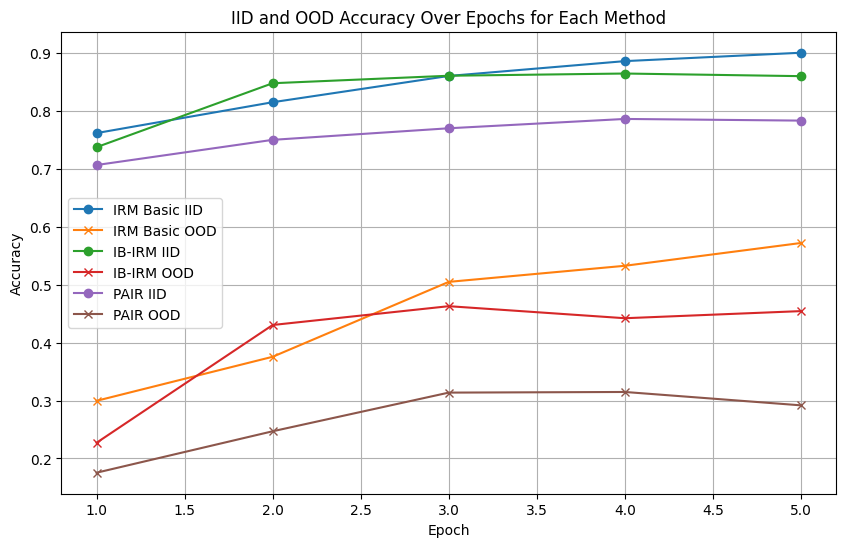

In [8]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10,6))

epochs = np.arange(1, len(next(iter(results.values()))['iid']) + 1)  # Number of epochs

for method in results:
    iid_acc = results[method]['iid']
    ood_acc = results[method]['ood']

    # Plot IID
    ax.plot(epochs, iid_acc, marker='o', label=f"{method} IID")
    # Plot OOD
    ax.plot(epochs, ood_acc, marker='x', label=f"{method} OOD")

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("IID and OOD Accuracy Over Epochs for Each Method")
ax.grid(True)
ax.legend()
plt.show()




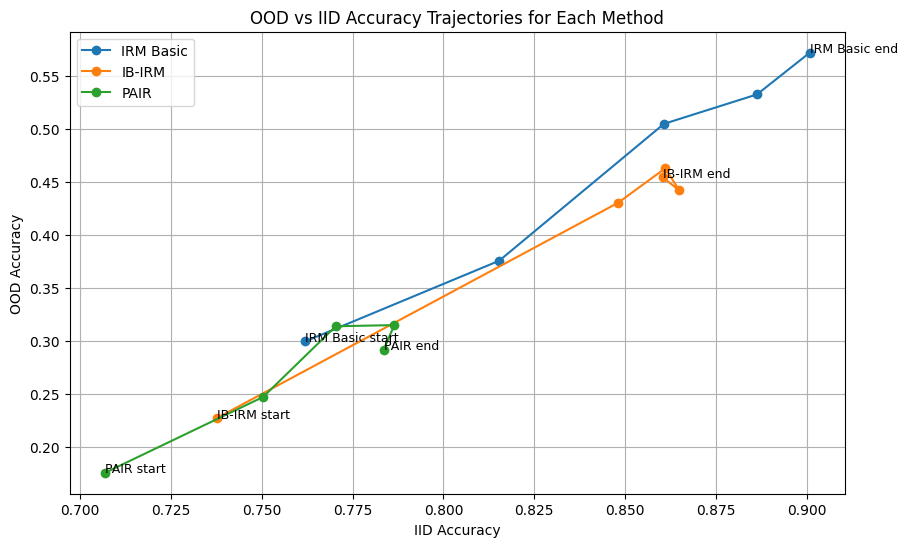

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

for method in results:
    iid_acc = results[method]['iid']
    ood_acc = results[method]['ood']

    ax.plot(iid_acc, ood_acc, marker='o', label=method)
    ax.text(iid_acc[0], ood_acc[0], f"{method} start", fontsize=9)
    ax.text(iid_acc[-1], ood_acc[-1], f"{method} end", fontsize=9)

ax.set_xlabel("IID Accuracy")
ax.set_ylabel("OOD Accuracy")
ax.set_title("OOD vs IID Accuracy Trajectories for Each Method")
ax.grid(True)
ax.legend()
plt.show()

In [7]:
print(results)

{'IRM Basic': {'iid': [0.7620233333333333, 0.8153566666666666, 0.86075, 0.8863633333333333, 0.9008733333333334], 'ood': [0.2995, 0.3756, 0.505, 0.5328, 0.5722]}, 'IB-IRM': {'iid': [0.73766, 0.8481633333333333, 0.8611066666666666, 0.8649333333333334, 0.8603833333333334], 'ood': [0.227, 0.4305, 0.463, 0.4422, 0.4545]}, 'PAIR': {'iid': [0.70685, 0.7503633333333333, 0.7703599999999999, 0.7864733333333334, 0.7835866666666667], 'ood': [0.1753, 0.2469, 0.3137, 0.3148, 0.2917]}}
